In [1]:
import random
import math
import time
import copy
import os
import pandas as pd
import numpy as np
import torch

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
import transformers
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

n_epochs = 10
batch_patience = 4
train_batch_size = 16
inference_batch_size = 128

stopping_stat = 'loss'

tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-large')
model = transformers.RobertaForSequenceClassification.from_pretrained('roberta-large')
model.classifier.out_proj = nn.Linear(in_features=1024, out_features=30, bias=True)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model = model.to(device)

train_optimizer = optim.AdamW(model.parameters(), lr=2e-5)
finetune_optimizer = train_optimizer
loss_fn = nn.CrossEntropyLoss(reduction='sum')

# train_steps = (6*34000)/32 ~ 6375.
scheduler = None # transformers.get_scheduler("linear", optimizer=train_optimizer, num_warmup_steps=100, num_training_steps=10000)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [3]:
DEBUG = False

In [4]:
class BookTitleDataset(Dataset):
    
    def __init__(self, df, test=False):
        self.df = df
        self.test = test
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        if self.test:
            return (idx, record['Title'])
        return (idx, record['Title'], record['Genre'])

In [5]:
def train_model(model, optimizer, lr_scheduler, iterator, batch_lim=128):
    
    model.train()
    loss, accuracy = 0, 0
    n_steps  = 0
    break_early = False
    
    for i in tqdm(range(batch_lim)):
        batch = next(iterator, None)
        if batch is None:
            break_early = True
            break
        idxs, titles, genres = batch
        tok_titles = tokenizer(list(titles), padding=True, truncation=True, return_tensors='pt')
        tok_titles = {k : v.to(device) for k,v in tok_titles.items()}        
        genres = genres.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(**tok_titles).logits
        _, preds = torch.max(outputs, 1)
        batch_loss = loss_fn(outputs, genres)
        
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.detach()
        accuracy += torch.count_nonzero(preds.detach() == genres)
        n_steps += 1

        if lr_scheduler:
            lr_scheduler.step()
                
    return {
        'loss': loss.cpu().item()/(train_batch_size*n_steps),
        'error': 1 - accuracy.cpu().item()/(train_batch_size*n_steps),
        'break_early': break_early
    }
    
def val_model(model, dataloader):
    model.eval()
    loss, accuracy = 0, 0
    n = len(dataloader.dataset)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            idxs, titles, genres = batch
            tok_titles = tokenizer(list(titles), padding=True, truncation=True, return_tensors='pt')
            tok_titles = {k : v.to(device) for k,v in tok_titles.items()}        
            genres = genres.to(device)

            outputs = model(**tok_titles).logits
            _, preds = torch.max(outputs, 1)
            batch_loss = loss_fn(outputs, genres)

            loss += batch_loss
            accuracy += torch.count_nonzero(preds == genres)
        
    return {
        'loss': loss.cpu().item()/n,
        'error': 1 - accuracy.cpu().item()/n
    }

def predict_model(model, dataloader):
    loss, accuracy = 0, 0
    n = len(dataloader.dataset)
    genres = torch.zeros(n, dtype=torch.long).to(device)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            idxs, titles = batch
            tok_titles = tokenizer(list(titles), padding=True, truncation=True, return_tensors='pt')
            tok_titles = {k : v.to(device) for k,v in tok_titles.items()}        

            outputs = model(**tok_titles).logits
            _, preds = torch.max(outputs, 1)
            genres[idxs] = preds
        
    return pd.DataFrame({'Genre': genres.cpu()}).rename_axis('Id')

def compute_total_norm():
    with torch.no_grad():
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
    return total_norm

def run(dataloaders, savepath='/kaggle/working'):
    
    train_stats, val_stats = [], []
    
    best_stat = 1e15
    patience_ctr = 0
    best_wts = None
    orig_wts = copy.deepcopy(model.state_dict())
    training_done = False
    
    print(f"Training Model")
    for i in range(1, n_epochs+1):
        print(f"\nEpoch {i}:")
        
        if training_done:
            break
        
        train_iterator = iter(dataloaders['train'])
        broke_early = False
        while not broke_early:
            train_stat = train_model(model, train_optimizer, scheduler, train_iterator)
            broke_early = train_stat['break_early']
            print("  Training:")
            for stat, value in train_stat.items():
                print(f"    {stat:6} = {value}")

            val_stat = val_model(model, dataloaders['val'])
            print("  Validation:")
            for stat, value in val_stat.items():
                print(f"    {stat:6} = {value}")

            total_norm = compute_total_norm()
            train_stat['norm'] = total_norm

            train_stats.append(train_stat)
            val_stats.append(val_stat)

            if (val_stat[stopping_stat] < best_stat):
                best_stat = val_stat[stopping_stat]
                best_wts = copy.deepcopy(model.state_dict())
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= batch_patience:
                    print(f"{stopping_stat} has not improved in {batch_patience} epochs. Stopping.")
                    training_done = True
                    break
    
    model.load_state_dict(best_wts)
    
    # finetuning - early stopping here as well?
    print(f"Finetuning Model")
    finetuning_done = False
    for i in range(1, n_epochs+1):
        print(f"Epoch {i}:")
        
        if finetuning_done:
            break
        
        finetune_iterator = iter(dataloaders['all'])
        broke_early = False
        while not broke_early:
            train_stat = train_model(model, train_optimizer, None, finetune_iterator)
            broke_early = train_stat['break_early']
            print("  Training:")
            for stat, value in train_stat.items():
                print(f"    {stat:6} = {value}")

            val_stat = val_model(model, dataloaders['val'])
            print("  Validation:")
            for stat, value in val_stat.items():
                print(f"    {stat:6} = {value}")

            total_norm = compute_total_norm()
            train_stat['norm'] = total_norm

            train_stats.append(train_stat)
            val_stats.append(val_stat)

            if (val_stat[stopping_stat] < best_stat):
                finetuning_done = True
                break

    torch.save(model, f'{savepath}/roberta.pt')
    
    return train_stats, val_stats

## Running

In [6]:
def process_df(df):
    df['Title'] = df['Title'].str.strip()
    df['Title'] = df['Title'].str.replace(r' [;,\.:] ', ' ', regex=True)
    df['Title'] = df['Title'].str.replace(r'^[;,\.:]', '', regex=True)
    df['Title'] = df['Title'].str.replace(r'[;,\.:]$', '', regex=True)
    df['Title'] = df['Title'].str.strip()
    return df

def load_train_df(x_path, y_path, debug_len=64):
    X = pd.read_csv(x_path)
    y = pd.read_csv(y_path)
    df = pd.merge(process_df(X), y, left_on='Id', right_on='Id', how='left')
    df.set_index('Id', inplace=True)
    return df.iloc[:debug_len] if DEBUG else df

def load_df(df_path, debug_len=64):
    df = pd.read_csv(df_path)
    df = df.set_index('Id')
    return df.iloc[:debug_len] if DEBUG else df

In [7]:
dpath = '/kaggle/input/col774-2022'
train_df = load_train_df(f'{dpath}/train_x.csv', f'{dpath}/train_y.csv', debug_len=128)
val_df = load_train_df(f'{dpath}/non_comp_test_x.csv', f'{dpath}/non_comp_test_y.csv', debug_len=32)
# gen_df = load_df('/kaggle/input/book-title-generator-data/gen_df.csv')
test_df = process_df(load_df(f'{dpath}/comp_test_x.csv'))

all_df = train_df.append(val_df, ignore_index=True)

train_df, val_df = np.split(all_df.sample(frac=1), [(int)(0.95*len(all_df))])
                                  
# train_df = train_df.append(gen_df.iloc[:-6000], ignore_index=True)
# gen_df = gen_df.iloc[-6000:]

In [8]:
dataloaders = {
    'train': DataLoader(BookTitleDataset(train_df), batch_size=train_batch_size, shuffle=True, num_workers=2),
    'val'  : DataLoader(BookTitleDataset(val_df), batch_size=inference_batch_size, shuffle=False, num_workers=2),
    'all'  : DataLoader(BookTitleDataset(all_df), batch_size=train_batch_size, shuffle=True, num_workers=2),
    'test' : DataLoader(BookTitleDataset(test_df, test=True), batch_size=inference_batch_size, shuffle=False, num_workers=2)
}

In [9]:
train_stats, val_stats = run(dataloaders)

Training Model

Epoch 1:


  0%|          | 0/128 [00:00<?, ?it/s]

  Training:
    loss   = 3.43949818611145
    error  = 0.96435546875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.433135818060777
    error  = 0.9679197994987468


  0%|          | 0/128 [00:00<?, ?it/s]

  Training:
    loss   = 3.435626983642578
    error  = 0.96923828125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4091840930451127
    error  = 0.9578947368421052


  0%|          | 0/128 [00:00<?, ?it/s]

  Training:
    loss   = 3.4209866523742676
    error  = 0.9697265625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4054672814849622
    error  = 0.9593984962406015


  0%|          | 0/128 [00:00<?, ?it/s]

  Training:
    loss   = 3.4210543632507324
    error  = 0.96240234375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.40148320018797
    error  = 0.9593984962406015


  0%|          | 0/128 [00:00<?, ?it/s]

  Training:
    loss   = 3.4146568775177
    error  = 0.96630859375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4027382910401003
    error  = 0.9538847117794487


  0%|          | 0/128 [00:00<?, ?it/s]

  Training:
    loss   = 3.416459321975708
    error  = 0.95556640625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.407284568843985
    error  = 0.9649122807017544


  0%|          | 0/128 [00:00<?, ?it/s]

  Training:
    loss   = 3.4120054244995117
    error  = 0.96923828125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.406174126723058
    error  = 0.9639097744360903


  0%|          | 0/128 [00:00<?, ?it/s]

  Training:
    loss   = 3.4132819175720215
    error  = 0.96875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.405122425203634
    error  = 0.9593984962406015
loss has not improved in 4 epochs. Stopping.

Epoch 2:
Finetuning Model
Epoch 1:


  0%|          | 0/128 [00:00<?, ?it/s]

  Training:
    loss   = 3.412203550338745
    error  = 0.95703125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.387249373433584
    error  = 0.9578947368421052
Epoch 2:


In [10]:
model.module.classifier.out_proj

Linear(in_features=1024, out_features=30, bias=True)

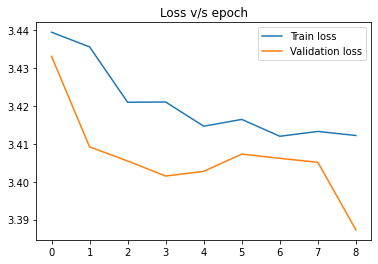

In [11]:
plt.plot([a['loss'] for a in train_stats], label='Train loss')
plt.plot([a['loss'] for a in val_stats], label='Validation loss')
plt.legend()
plt.title("Loss v/s epoch")
plt.show()

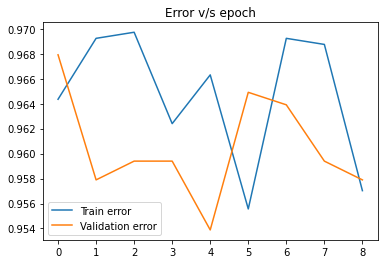

In [12]:
plt.plot([a['error'] for a in train_stats], label='Train error')
plt.plot([a['error'] for a in val_stats], label='Validation error')
plt.legend()
plt.title("Error v/s epoch")
plt.show()

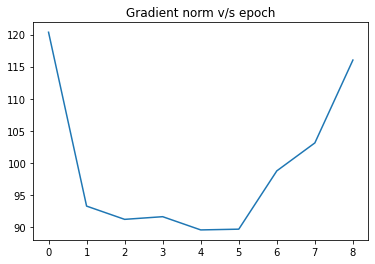

In [13]:
plt.plot([a['norm'] for a in train_stats], label='norm')
plt.title("Gradient norm v/s epoch")
plt.show()

In [14]:
preds = predict_model(model, dataloaders['test'])
preds.to_csv(f"/kaggle/working/submission.csv")

  0%|          | 0/90 [00:00<?, ?it/s]